# 1. Radius - density - mass relation estimator

**Author: [Hannu Parviainen](mailto:hpparvi@gmail.com)** </br>
**Last edited: 12.12.2022**

An example notebook showing how to use `moot.RMEstimator` to calculate a custom radius - density - mass (RDM) relation posterior maps for small planets orbiting M dwarfs assuming that the planets can be divided into three main density categories: rocky planets, water-rich planets, and puffy sub-Neptunes, as proposed by [Luque & Pallé](https://ui.adsabs.harvard.edu/abs/2022Sci...377.1211L/abstract). The maps are used by `moot.RMRelation` to infer density or mass posteriors given a planet radius with its uncertainty.

**Note:** The `moot` package comes with a default RDM relation map calculated using the latest reliable radius and mass measurements published by the date of the version release. Ceating a custom map should not be necessary unless you want to a) include proprietary information, b) test how sensitive the mass posteriors are on model priors, or c) test how sensitive the mass posteriors are on the chosen planet radius and mass measurements. 

## Theory

The probabilistic radius - density relation implemented by `moot` models the probability for a planet's bulk density ($\rho$) given a planet radius ($r$) as a mixture of three generalised (scaled and transformed) Student's T distributions, representing the distributions of rocky planets (r),  water worlds (w), and sub-Neptunes (p for puffy)

\begin{equation}
P(\rho|r,\vec{\theta}) = w_\mathrm{r} T_\mathrm{r} + w_\mathrm{w} T_\mathrm{w} +  w_\mathrm{p} T_\mathrm{p}, \; \text{where}\; w_\mathrm{r} + w_\mathrm{w} + w_\mathrm{p} = 1.
\end{equation}

The mixture weights, $w_\mathrm{r}$, $w_\mathrm{w}$, and $w_\mathrm{p}$ are obtained through [interpolation inside a 2D triangle](https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Conversion_between_barycentric_and_Cartesian_coordinates) defined by the three composition classes: *rocky planets* (0,0), *water worlds*  (0,1), and *sub-Neptunes* (1,0), as

\begin{align*}
    w1 &= 1. - x - y,\\
    w2 &= y,\\
    w3 &= 1. - w1 - w2,
\end{align*}

and the $(x,y)$ coordinates are mapped from the planet radius, $r$, rocky-water transition start and end radii, $a_1$ and $a_2$, and the water-puffy transition start and end radii, $b_1$ and $b_2$, as

<!--- 
\begin{align*}
x &= \Bigl\lfloor \frac{r-b_1}{b_2-b_1} \Bigr\rceil,\\
y &= \Bigl\lfloor \Bigl\lfloor \frac{r-a_1}{a_2-a_1} \Bigr\rceil - x \Bigr\rceil,
\end{align*}
--->

\begin{align*}
x &= \underset{0}{\Bigl\lfloor} \frac{r-b_1}{b_2-b_1} \overset{1}{\Bigr\rceil},\\
y &= \underset{0}{\Bigl\lfloor} \underset{0}{\Bigl\lfloor} \frac{r-a_1}{a_2-a_1} \overset{1}{\Bigr\rceil} - x \overset{1}{\Bigr\rceil},
\end{align*}

where $\underset{a}{\bigl\lfloor} x \overset{b}{\bigr\rceil}$ denotes (rather unorthodoxly) clipping the the value $x$ between $a$ and $b$, that is, $\underset{a}{\bigl\lfloor} x \overset{b}{\bigr\rceil} = \max(a, \min(x, b))$.

The three generalised Student's T distributions are


\begin{equation*}
    P_\mathrm{r}(\rho|r, a, s_\mathrm{r}, \lambda_\mathrm{r}) = T(\rho_\mathrm{r}(a, r), s_\mathrm{r}, \lambda_\mathrm{r}),
\end{equation*}

\begin{equation*}
    P_\mathrm{w}(\rho|r, b, s_\mathrm{w}, \lambda_\mathrm{w}) = T(\rho_\mathrm{w}(b, r), s_\mathrm{w}, \lambda_\mathrm{w}),
\end{equation*}

\begin{equation*}
    P_\mathrm{p}(\rho|r, c, d, s_\mathrm{p}, \lambda_\mathrm{p}) = T(c + d(r-2.2), s_\mathrm{p}, \lambda_\mathrm{p}),
\end{equation*}

where $s$ are the distribution scale and $\lambda$ are the degrees of freedom. The location of each distribution ($\hat{\mu}$ or the *mean function* from now on, even though it's not a "mean" function in the literal sense since we're using Student's T distributions) depends on the planet radius and an additional parameter for the rocky and water-rich planets, and two additional parameters for the sub-Neptunes.

The radius-density model uses the bulk densities derived from the [Zeng mass-radius relations](https://lweb.cfa.harvard.edu/~lzeng/planetmodels.html) as the mean functions for the rocky and water-rich planets, and a simple slope for the sub-Neptunes. For rocky planets, $a$ is the iron-rock mixing fraction, and for water-rich planets, $b$ is the h$_2$o-rock mixing fraction.

In [1]:
%matplotlib inline

from matplotlib.pyplot import subplots, rc, setp
from corner import corner

## Initialise RMEstimator

First, we initialise the `RMEstimator` by giving it the number of samples to use per planet, and either a set of planet names, radii, and masses (or densities), as 

    RMEstimator(nsamples=50, names=planet_names, radii=(r_means, r_errors), masses=(m_means, m_errors))
    
or by giving it a `csv` file following the Luque et al. formatting, as done here.

In [2]:
from moot import RMEstimator

In [3]:
mre = RMEstimator(nsamples=100, tbl_file='../moot/data/STPM_improved_210721.csv', use_tabulated_rho=False)

## Optimise the posterior

Next, we find the posterior mode (the best-fitting model solution given the priors) from where the posterior sampling will be started. We can also plot the model for the posterior-mode solution, but don't expect it to model the distribution too well. This is only a single solution and the mass-density model is relatively simple, and the final mass-density model needs to be averaged over all the solutions allowed by the observations, as done in the next step.

In [5]:
mre.optimize()

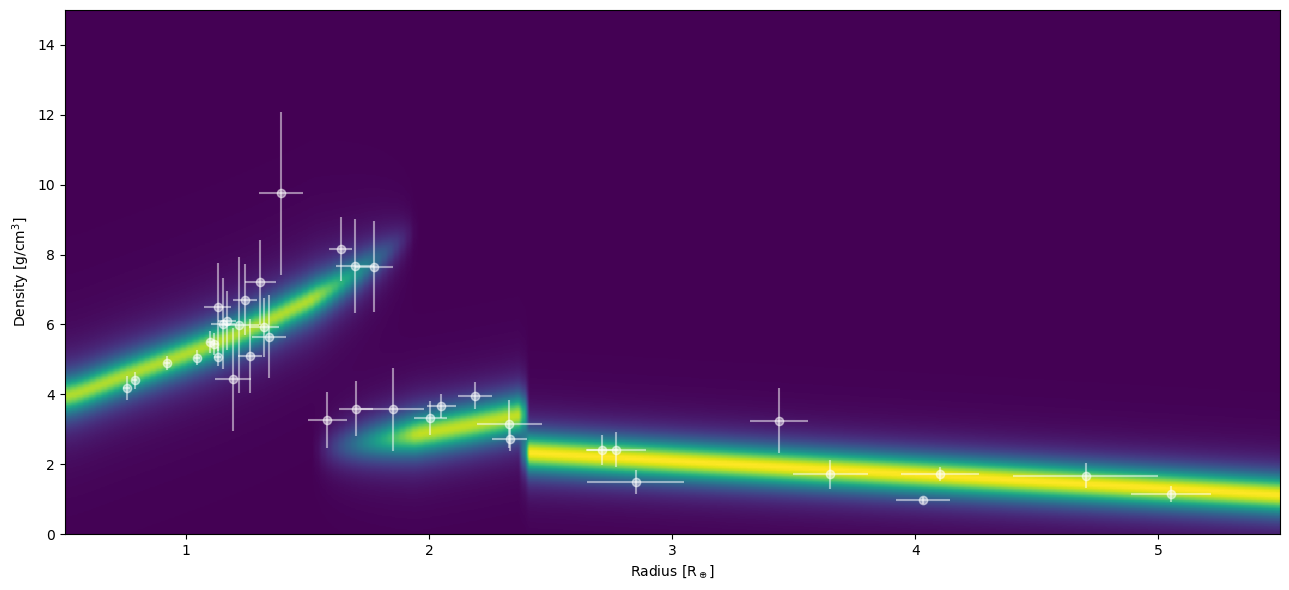

In [6]:
fig, ax = subplots(figsize=(13,6))
mre.plot_radius_density(ax=ax)
fig.tight_layout()

## Obtain a posterior sample
Next, we sample the posterior to obtain a number of model parameter samples that agree with the observations.

In [11]:
mre.sample_mcmc(6000, thin=150, repeats=3)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/6000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/6000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/6000 [00:00<?, ?it/s]

### Plot the posterior model

Now, we can plot the radius-density model averaged over the posterior samples. This averaged model corresponds to the model solutions that can explain the observed masses and radii within their uncertainties.

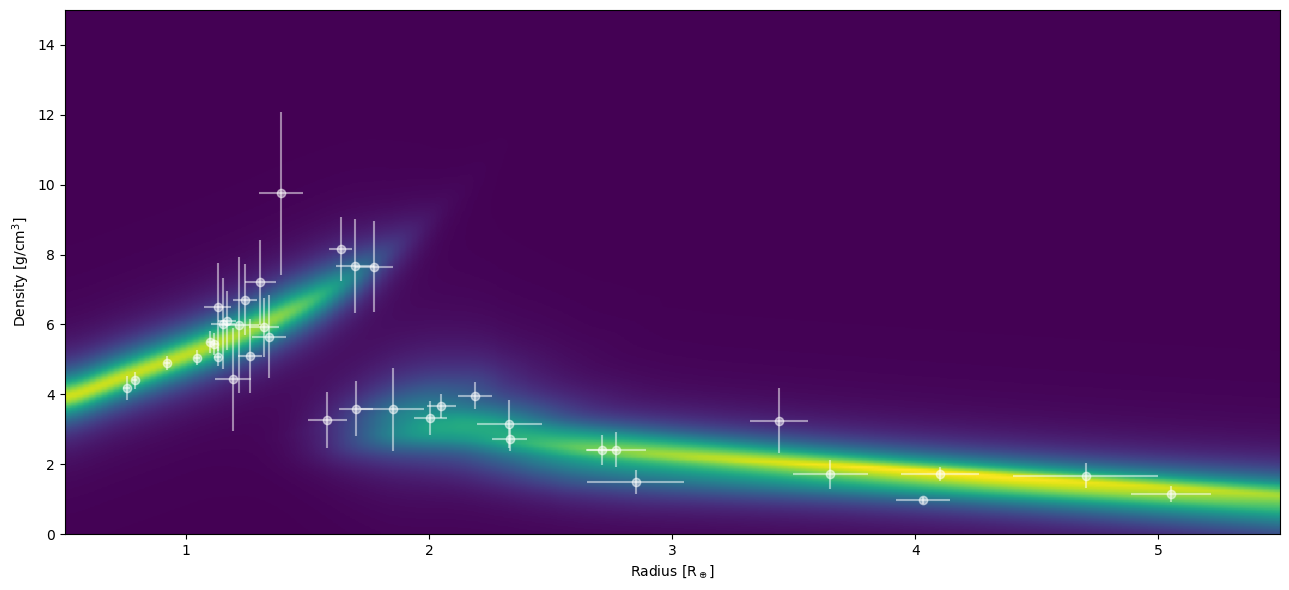

In [12]:
fig, ax = subplots(figsize=(13,6))
mre.plot_radius_density(max_samples=250, ax=ax)
fig.tight_layout()

### Take a look at the parameter posteriors

In [13]:
df = mre.posterior_samples()

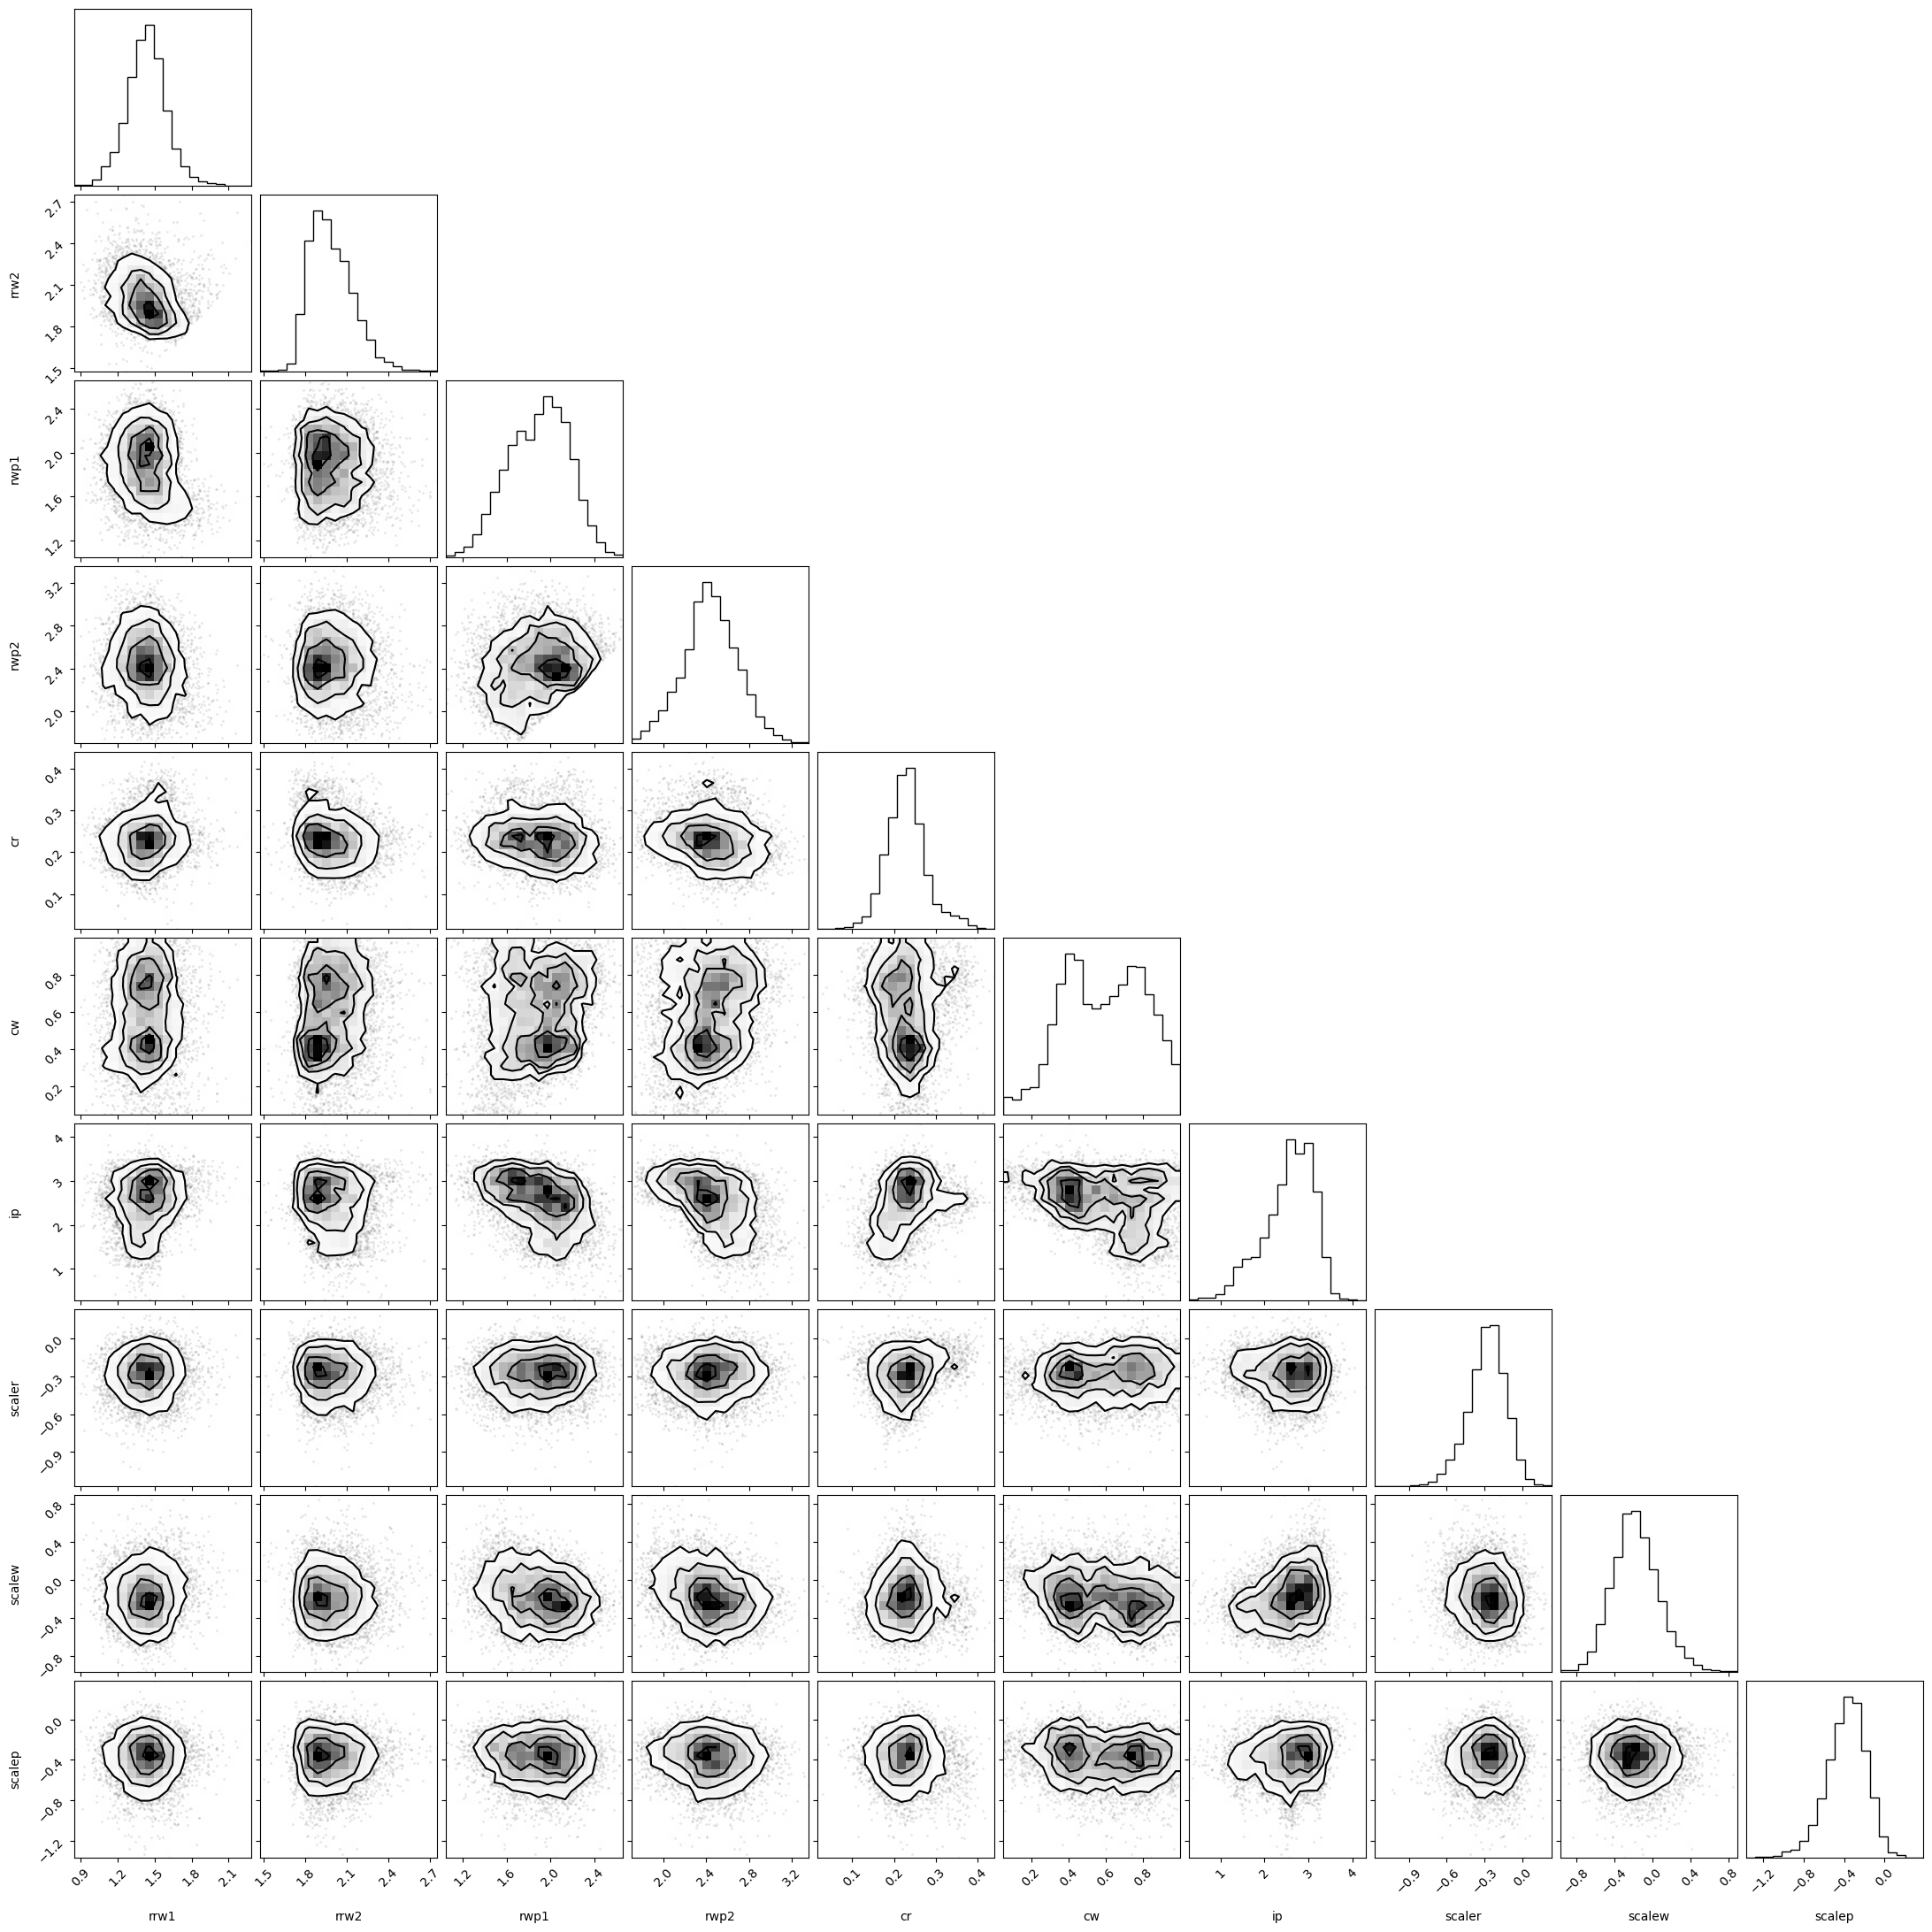

In [14]:
corner(data=df.iloc[:,:10].values, labels=df.columns);

## Compute and save the posterior and ICDF maps

In [15]:
mre.compute_maps()

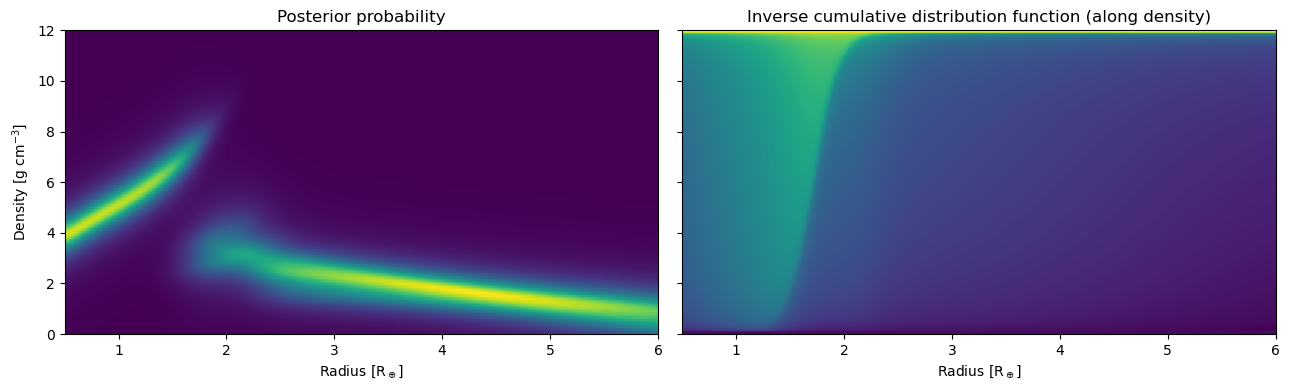

In [16]:
fig, axs = subplots(1, 2, figsize=(13, 4), sharey='all')
axs[0].imshow(mre.rdmap.T, origin='lower', aspect='auto', extent=(mre._ra[0], mre._ra[-1], mre._da[0], mre._da[-1]))
axs[1].imshow(mre.icdf.T, origin='lower', aspect='auto', extent=(mre._ra[0], mre._ra[-1], mre._da[0], mre._da[-1]))
setp(axs[0], ylabel='Density [g cm$^{-3}$]', title='Posterior probability')
setp(axs[1], title='Inverse cumulative distribution function (along density)')
setp(axs, xlabel='Radius [R$_\oplus$]')

fig.tight_layout()

In [17]:
mre.save()

---

<center>
©2022 Hannu Parviainen
</center>